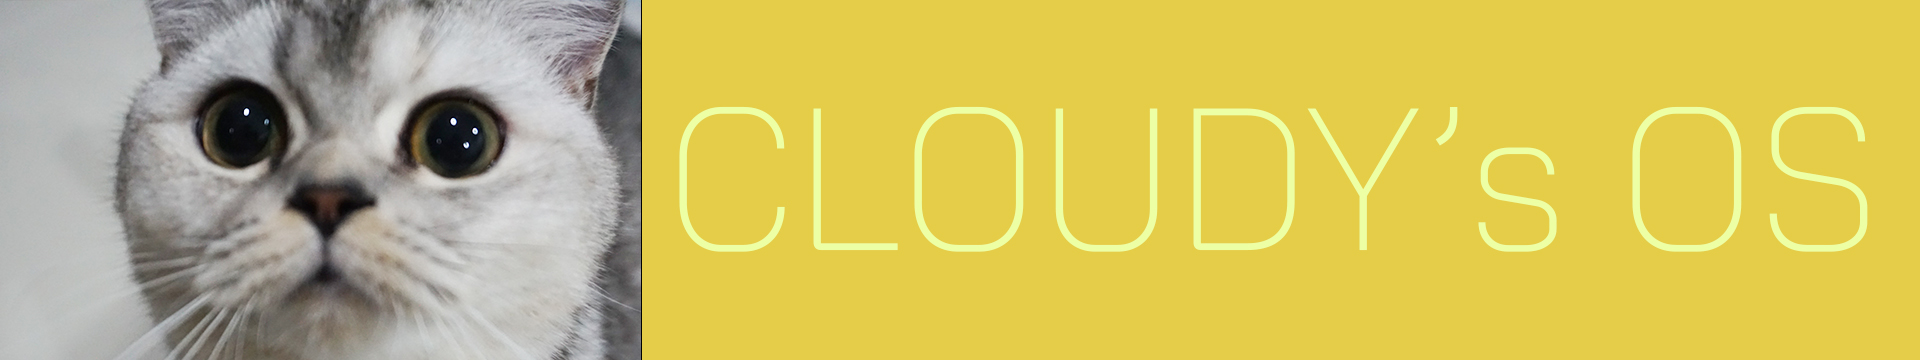

# Cloudy's OS: Audio Emotion Analysis
## ITCS225 Principles of Operating Systems - Group Project

### Team Members
* 6688077 Bhumipat Pengpaiboon
* 6688108 Napas Siripaskrittakul
* 6688142 Krerkkiat Wattanaporn

### Introduction:

This project aims to develop and predict the human emotion by their speech (specifically Angry, Frustrated, Happy, Neutral, and Sad) directly from Thai speech audio dataset named THAI SER dataset.

A key focus of this project is to analyze and optimize the computational performance and how we optimize it:
1. A **Standard Sequential Version or First Version:** Processes audio files one by one.
2. An **Optimized Parallel Version or Enchanced Version:** Using (`multiprocessing` by `joblib`) to doing multi-core computation in CPU.

The primary optimization goal is to significantly reduce the execution time of the feature extraction stage by doing parallelizing when running the code and shows that how OS is doing parallelism can enhance the performance in machine learning tasks. Both versions will be compared for computational performance (time, CPU, memory) and predict accuracy of the machine learning.

### First Version

In [1]:
import os
import json
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import soundfile as sf
import time
import joblib
import psutil # Import psutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

process = psutil.Process(os.getpid())

data_dir = './Dataset/'
metadata_file = os.path.join(data_dir, 'emotion_label.json')
emotion_map = {'โกรธ': 'angry', 'เศร้า': 'sad', 'สุข': 'happy', 'หงุดหงิด': 'frustrated', 'ปกติ': 'neutral'}
target_emotions = ['angry', 'sad', 'happy', 'frustrated', 'neutral']
sample_rate = 44100
n_mfcc = 13
max_len = 500
model_type = 'MLP'

def get_filepath(filename_stem):
    try:
        parts = filename_stem.split('_')
        if len(parts) < 3: return None
        rec_id, mic_type = parts[0], parts[1]
        rec_type = rec_id[0]
        rec_num = int(rec_id[1:])
        group_start = ((rec_num - 1) // 10) * 10 + 1
        group_end = group_start + 9
        if rec_type == 's':
            group_dir = f"studio{group_start}-{group_end}"
            session_dir = f"studio{rec_num:03d}"
            relative_path = os.path.join(group_dir, session_dir, mic_type)
        elif rec_type == 'z':
            group_dir = f"zoom{group_start}-{group_end}"
            session_dir = f"zoom{rec_num:03d}"
            relative_path = os.path.join(group_dir, session_dir, 'mic')
        else: return None
        full_path = os.path.join(data_dir, relative_path, filename_stem)
        if not os.path.splitext(full_path)[1]: full_path += ".flac"
        return full_path
    except Exception: return None

def extract_features(filepath, n_mfcc=n_mfcc, max_len=max_len, sr=sample_rate):
    try:
        audio, rate = librosa.load(filepath, sr=sr, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc=n_mfcc)
        if mfccs.shape[1] > max_len: mfccs = mfccs[:, :max_len]
        else:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfccs.T
    except Exception: return np.zeros((max_len, n_mfcc))

def process_metadata(metadata_file):
    try:
        with open(metadata_file, 'r', encoding='utf-8') as f: raw_meta = json.load(f)
    except Exception: raw_meta = {}
    file_rows = []
    target_emotions_lower = [e.lower() for e in target_emotions]
    if isinstance(raw_meta, dict):
        for filename_stem, entry_list in raw_meta.items():
            if isinstance(entry_list, list) and entry_list:
                emotion_dict = entry_list[0]
                if isinstance(emotion_dict, dict):
                    emotion_label = emotion_dict.get('majority_emo')
                    if emotion_label and emotion_label.lower() in target_emotions_lower:
                        full_path = get_filepath(filename_stem)
                        if full_path and os.path.exists(full_path):
                            file_rows.append({'stem': filename_stem, 'path': full_path, 'label': emotion_label})
    return pd.DataFrame(file_rows)

def create_model(model_type='MLP'):
     if model_type == 'MLP':
        return MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, max_iter=300, shuffle=True, random_state=42, early_stopping=True, n_iter_no_change=10, verbose=False)
     elif model_type == 'SVM':
        return SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42, verbose=False)
     else: raise ValueError("Invalid model_type")

def print_resources(stage_name, start_time, end_time):
    cpu_times = process.cpu_times()
    mem_info = process.memory_info()
    print(f"{stage_name} Time: {end_time - start_time:.2f}s")
    print(f"  CPU Times @ end: user={cpu_times.user:.2f}s, system={cpu_times.system:.2f}s")
    print(f"  Memory Usage @ end: RSS={mem_info.rss / (1024**2):.2f} MB")

overall_start = time.time()
init_cpu_times = process.cpu_times()
init_mem_info = process.memory_info()
print(f"Initial CPU Times: user={init_cpu_times.user:.2f}s, system={init_cpu_times.system:.2f}s")
print(f"Initial Memory Usage: RSS={init_mem_info.rss / (1024**2):.2f} MB")


start_meta = time.time()
df_meta = process_metadata(metadata_file)
end_meta = time.time()
print_resources("Metadata", start_meta, end_meta)


X_list = []
y_list = []
start_feat = time.time()
if not df_meta.empty:
    for index, row in tqdm(df_meta.iterrows(), total=len(df_meta), desc="Standard FeatExtract"):
        features = extract_features(row['path'])
        X_list.append(features.flatten())
        y_list.append(row['label'])
    X = np.array(X_list)
    y = np.array(y_list)
else:
    X, y = np.array([]), np.array([])
    print("Metadata empty, skipping feature extraction.")
end_feat = time.time()
print_resources("Feature Extraction", start_feat, end_feat)


start_prep = time.time()
if X.size > 0:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
else:
    print("No data to preprocess.")
end_prep = time.time()
print_resources("Preprocessing", start_prep, end_prep)


start_train = time.time()
model = None
if 'X_train_scaled' in locals() and X_train_scaled.size > 0:
    model = create_model(model_type)
    model.fit(X_train_scaled, y_train)
else:
    print("No data to train.")
end_train = time.time()
print_resources("Training", start_train, end_train)


start_eval = time.time()
accuracy = 0
report = "Evaluation skipped."
if model is not None and 'X_test_scaled' in locals() and X_test_scaled.size > 0:
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
else:
    print("Evaluation skipped.")
end_eval = time.time()
print_resources("Evaluation", start_eval, end_eval)


overall_end = time.time()
print(f"\n--- Standard Version Total Wall Time: {overall_end - overall_start:.2f}s ---")
final_cpu_times = process.cpu_times()
final_mem_info = process.memory_info()
print(f"Final CPU Times: user={final_cpu_times.user:.2f}s, system={final_cpu_times.system:.2f}s")
print(f"Final Memory Usage: RSS={final_mem_info.rss / (1024**2):.2f} MB")
print(f"\nAccuracy: {accuracy:.4f}")
print(report)

Initial CPU Times: user=3.09s, system=0.11s
Initial Memory Usage: RSS=209.91 MB
Metadata Time: 0.39s
  CPU Times @ end: user=3.44s, system=0.16s
  Memory Usage @ end: RSS=257.47 MB


Standard FeatExtract: 100%|██████████| 25185/25185 [10:14<00:00, 40.95it/s]


Feature Extraction Time: 615.14s
  CPU Times @ end: user=6484.82s, system=9.67s
  Memory Usage @ end: RSS=1700.66 MB
Preprocessing Time: 1.41s
  CPU Times @ end: user=6485.95s, system=9.94s
  Memory Usage @ end: RSS=3137.56 MB
Training Time: 25.62s
  CPU Times @ end: user=6752.82s, system=10.42s
  Memory Usage @ end: RSS=3142.91 MB
Evaluation Time: 0.04s
  CPU Times @ end: user=6753.26s, system=10.42s
  Memory Usage @ end: RSS=3145.54 MB

--- Standard Version Total Wall Time: 642.60s ---
Final CPU Times: user=6753.26s, system=10.42s
Final Memory Usage: RSS=3145.54 MB

Accuracy: 0.4714
              precision    recall  f1-score   support

       Angry       0.48      0.42      0.44       467
  Frustrated       0.43      0.51      0.47      1180
       Happy       0.44      0.45      0.44       610
     Neutral       0.56      0.54      0.55      1104
         Sad       0.39      0.28      0.32       417

    accuracy                           0.47      3778
   macro avg       0.46     

## Enchanced Version

In [1]:
import os
import json
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import soundfile as sf
import time
import joblib
from joblib import Parallel, delayed
import psutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
process = psutil.Process(os.getpid())

data_dir = './Dataset/'
metadata_file = os.path.join(data_dir, 'emotion_label.json')
emotion_map = {'โกรธ': 'angry', 'เศร้า': 'sad', 'สุข': 'happy', 'หงุดหงิด': 'frustrated', 'ปกติ': 'neutral'}
target_emotions = ['angry', 'sad', 'happy', 'frustrated', 'neutral']
sample_rate = 44100
n_mfcc = 13
max_len = 500
model_type = 'MLP'

def get_filepath(filename_stem):
    try:
        parts = filename_stem.split('_')
        if len(parts) < 3: return None
        rec_id, mic_type = parts[0], parts[1]
        rec_type = rec_id[0]
        rec_num = int(rec_id[1:])
        group_start = ((rec_num - 1) // 10) * 10 + 1
        group_end = group_start + 9
        if rec_type == 's':
            group_dir = f"studio{group_start}-{group_end}"
            session_dir = f"studio{rec_num:03d}"
            relative_path = os.path.join(group_dir, session_dir, mic_type)
        elif rec_type == 'z':
            group_dir = f"zoom{group_start}-{group_end}"
            session_dir = f"zoom{rec_num:03d}"
            relative_path = os.path.join(group_dir, session_dir, 'mic')
        else: return None
        full_path = os.path.join(data_dir, relative_path, filename_stem)
        if not os.path.splitext(full_path)[1]: full_path += ".flac"
        return full_path
    except Exception: return None

def extract_features(filepath, n_mfcc=n_mfcc, max_len=max_len, sr=sample_rate):
    try:
        audio, rate = librosa.load(filepath, sr=sr, res_type='kaiser_fast')
        mfccs = librosa.feature.mfcc(y=audio, sr=rate, n_mfcc=n_mfcc)
        if mfccs.shape[1] > max_len: mfccs = mfccs[:, :max_len]
        else:
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        return mfccs.T
    except Exception: return np.zeros((max_len, n_mfcc))

def process_metadata(metadata_file):
    try:
        with open(metadata_file, 'r', encoding='utf-8') as f: raw_meta = json.load(f)
    except Exception: raw_meta = {}
    file_rows = []
    target_emotions_lower = [e.lower() for e in target_emotions]
    if isinstance(raw_meta, dict):
        for filename_stem, entry_list in raw_meta.items():
            if isinstance(entry_list, list) and entry_list:
                emotion_dict = entry_list[0]
                if isinstance(emotion_dict, dict):
                    emotion_label = emotion_dict.get('majority_emo')
                    if emotion_label and emotion_label.lower() in target_emotions_lower:
                        full_path = get_filepath(filename_stem)
                        if full_path and os.path.exists(full_path):
                            file_rows.append({'stem': filename_stem, 'path': full_path, 'label': emotion_label})
    return pd.DataFrame(file_rows)

def create_model(model_type='MLP'):
     if model_type == 'MLP':
        return MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, batch_size='auto', learning_rate='adaptive', learning_rate_init=0.001, max_iter=300, shuffle=True, random_state=42, early_stopping=True, n_iter_no_change=10, verbose=False)
     elif model_type == 'SVM':
        return SVC(C=1.0, kernel='rbf', gamma='scale', random_state=42, verbose=False)
     else: raise ValueError("Invalid model_type")

def print_resources(stage_name, start_time, end_time):
    cpu_times = process.cpu_times()
    mem_info = process.memory_info()
    print(f"{stage_name} Time: {end_time - start_time:.2f}s")
    print(f"  CPU Times @ end: user={cpu_times.user:.2f}s, system={cpu_times.system:.2f}s")
    print(f"  Memory Usage @ end: RSS={mem_info.rss / (1024**2):.2f} MB")

overall_start = time.time()
init_cpu_times = process.cpu_times()
init_mem_info = process.memory_info()
print(f"Initial CPU Times: user={init_cpu_times.user:.2f}s, system={init_cpu_times.system:.2f}s")
print(f"Initial Memory Usage: RSS={init_mem_info.rss / (1024**2):.2f} MB")

start_meta = time.time()
df_meta = process_metadata(metadata_file)
end_meta = time.time()
print_resources("Metadata", start_meta, end_meta)

X = np.array([])
y = np.array([])
start_feat = time.time()
if not df_meta.empty:
    filepaths = df_meta['path'].tolist()
    results = Parallel(n_jobs=-1, backend='loky', verbose=0)(
        delayed(extract_features)(fp) for fp in tqdm(filepaths, desc="Parallel FeatExtract")
        )

    if results and all(isinstance(r, np.ndarray) for r in results):
         X_list = [res.flatten() for res in results]
         X = np.vstack(X_list)
         y = df_meta['label'].values
    else:
        print("Parallel feature extraction failed or returned unexpected results.")
        X, y = np.array([]), np.array([])
else:
    print("Metadata empty, skipping feature extraction.")
end_feat = time.time()
print_resources("Feature Extraction", start_feat, end_feat)


start_prep = time.time()
if X.size > 0:
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
else:
    print("No data to preprocess.")
end_prep = time.time()
print_resources("Preprocessing", start_prep, end_prep)


start_train = time.time()
model = None
if 'X_train_scaled' in locals() and X_train_scaled.size > 0:
    model = create_model(model_type)
    model.fit(X_train_scaled, y_train)
else:
    print("No data to train.")
end_train = time.time()
print_resources("Training", start_train, end_train)


start_eval = time.time()
accuracy = 0
report = "Evaluation skipped."
if model is not None and 'X_test_scaled' in locals() and X_test_scaled.size > 0:
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0)
else:
    print("Evaluation skipped.")
end_eval = time.time()
print_resources("Evaluation", start_eval, end_eval)


overall_end = time.time()
print(f"\n--- Parallel Version Total Wall Time: {overall_end - overall_start:.2f}s ---")
final_cpu_times = process.cpu_times()
final_mem_info = process.memory_info()
print(f"Final CPU Times: user={final_cpu_times.user:.2f}s, system={final_cpu_times.system:.2f}s")
print(f"Final Memory Usage: RSS={final_mem_info.rss / (1024**2):.2f} MB")
print(f"\nAccuracy: {accuracy:.4f}")
print(report)

Initial CPU Times: user=3.09s, system=0.12s
Initial Memory Usage: RSS=210.20 MB
Metadata Time: 0.35s
  CPU Times @ end: user=3.39s, system=0.17s
  Memory Usage @ end: RSS=257.81 MB


Parallel FeatExtract: 100%|██████████| 25185/25185 [01:53<00:00, 221.17it/s]


Feature Extraction Time: 115.40s
  CPU Times @ end: user=20.83s, system=2.46s
  Memory Usage @ end: RSS=2145.20 MB
Preprocessing Time: 1.56s
  CPU Times @ end: user=21.90s, system=2.95s
  Memory Usage @ end: RSS=3582.18 MB
Training Time: 30.29s
  CPU Times @ end: user=337.88s, system=3.23s
  Memory Usage @ end: RSS=3629.14 MB
Evaluation Time: 0.05s
  CPU Times @ end: user=338.42s, system=3.23s
  Memory Usage @ end: RSS=3631.64 MB

--- Parallel Version Total Wall Time: 147.65s ---
Final CPU Times: user=338.42s, system=3.23s
Final Memory Usage: RSS=3631.64 MB

Accuracy: 0.4656
              precision    recall  f1-score   support

       Angry       0.48      0.44      0.46       467
  Frustrated       0.45      0.42      0.43      1180
       Happy       0.44      0.41      0.43       610
     Neutral       0.51      0.62      0.56      1104
         Sad       0.38      0.31      0.34       417

    accuracy                           0.47      3778
   macro avg       0.45      0.44     

Exception ignored in: <function ResourceTracker.__del__ at 0x7ce95979a980>
Traceback (most recent call last):
  File "/home/icebear_bares/anaconda3/envs/cloudy-os/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/icebear_bares/anaconda3/envs/cloudy-os/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/icebear_bares/anaconda3/envs/cloudy-os/lib/python3.12/multiprocessing/resource_tracker.py", line 111, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x77bdf549a980>
Traceback (most recent call last):
  File "/home/icebear_bares/anaconda3/envs/cloudy-os/lib/python3.12/multiprocessing/resource_tracker.py", line 77, in __del__
  File "/home/icebear_bares/anaconda3/envs/cloudy-os/lib/python3.12/multiprocessing/resource_tracker.py", line 86, in _stop
  File "/home/icebear_bares/anaconda3/envs/cloudy-os/lib/python3.12/multiprocessing/resource_tracke